In [1]:
import random
import pandas as pd
from faker import Faker

fake = Faker()
random.seed(42)

# Define risk levels
risk_levels = ['safe', 'at_risk', 'immediate_danger']

# Sentences for each risk level
def generate_sentence(label, fake_case=False):
    emojis = {
        'safe': ['🙂', '💚', '✨', '🌻'],
        'at_risk': ['😟', '💔', '😥', '😓'],
        'immediate_danger': ['😰', '💢', '🆘', '💀']
    }
    children_mentions = [
        "my kids were home", "our daughter asked why we were yelling",
        "he never gets violent when the kids are around", "I told the children to stay in their room"
    ]
    calm_day = [
        "Today was peaceful", "We didn't argue at all today", "Everything felt calm for once", 
        "I even smiled today 🙂"
    ]
    at_risk_cases = [
        "He yelled at me again, but didn’t hit me", 
        "He came home drunk and punched the wall", 
        "He threw my phone across the room 💔", 
        "I locked myself in the bathroom to avoid him"
    ]
    danger_cases = [
        "He strangled me while I was screaming 🆘", 
        "I ran out barefoot after he pulled a knife 💀", 
        "He threatened to kill me and the kids", 
        "I sent my sister a voice note before he smashed my phone"
    ]
    manipulative_safe = [
        "I said he hit me but I just wanted him out", 
        "I reported him because I wanted custody of our child", 
        "I told my mom I was scared even though we were okay"
    ]
    
    base = ""
    if fake_case:
        base = random.choice(manipulative_safe)
    elif label == 'safe':
        base = random.choice(calm_day)
    elif label == 'at_risk':
        base = random.choice(at_risk_cases)
    elif label == 'immediate_danger':
        base = random.choice(danger_cases)
        
    # Occasionally add children context
    if random.random() < 0.3:
        base += ". " + random.choice(children_mentions)
        
    # Occasionally add emojis
    if random.random() < 0.6:
        base += " " + random.choice(emojis[label])
    
    return base.strip()

# Generate dataset
data = []
for label in risk_levels:
    for _ in range(500):
        is_fake = False
        if label in ['at_risk', 'immediate_danger'] and random.random() < 0.1:
            is_fake = True
        entry = {
            'text': generate_sentence(label, fake_case=is_fake),
            'risk_level': label,
            'age': random.randint(18, 65),
            'is_fake_report': is_fake
        }
        data.append(entry)

# Create DataFrame
df = pd.DataFrame(data)

# Shuffle it
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Export to CSV
df.to_csv("femicide_simulated_dataset.csv", index=False)

print("Dataset generated and saved as 'femicide_simulated_dataset.csv'")


Dataset generated and saved as 'femicide_simulated_dataset.csv'


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as snS
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### DATA LOADING 

In [3]:
#loading datset
df = pd.read_csv('femicide_simulated_dataset.csv')
df.head()

,text,risk_level,age,is_fake_report
0,I reported him because I wanted custody of our...,immediate_danger,57,True
1,He strangled me while I was screaming 🆘. our d...,immediate_danger,46,False
2,I even smiled today 🙂 🙂,safe,20,False
3,Today was peaceful. he never gets violent when...,safe,52,False
4,Today was peaceful 🙂,safe,18,False


In [4]:
df.shape

(1500, 4)

In [5]:
#checking for the class distribution
print(df['risk_level'].value_counts())
# Sample from each class
for label in df['risk_level'].unique():
    print(f"\n=== {label.upper()} ===")
    print(df[df['risk_level'] == label]['text'].sample(2).values)


risk_level
immediate_danger    500
safe                500
at_risk             500
Name: count, dtype: int64

=== IMMEDIATE_DANGER ===
['I ran out barefoot after he pulled a knife 💀 💢'
 'He threatened to kill me and the kids. he never gets violent when the kids are around 💀']

=== SAFE ===
['Today was peaceful 🌻' 'Today was peaceful 💚']

=== AT_RISK ===
['He threw my phone across the room 💔 💔'
 'He threw my phone across the room 💔']


### DATA CLEANING

In [6]:

print("Missing values per column", df.isnull().sum())

# View percentage of missing values
missing_percent = df.isnull().mean() * 100
print("Missing % per column:", missing_percent)

# Display sample rows with missing values 
if df.isnull().values.any():
    display(df[df.isnull().any(axis=1)].head())
else:
    print("\n No missing values found.")

Missing values per column text              0
risk_level        0
age               0
is_fake_report    0
dtype: int64
Missing % per column: text              0.0
risk_level        0.0
age               0.0
is_fake_report    0.0
dtype: float64

 No missing values found.


In [7]:
# delete the df_clean variable
if 'df_clean' in locals():
    del df_clean

# Reload the full original dataset 
df = pd.read_csv("femicide_simulated_dataset.csv")

# List the columns
print(df.columns)
df.head(10)


Index(['text', 'risk_level', 'age', 'is_fake_report'], dtype='object')


,text,risk_level,age,is_fake_report
0,I reported him because I wanted custody of our...,immediate_danger,57,True
1,He strangled me while I was screaming 🆘. our d...,immediate_danger,46,False
2,I even smiled today 🙂 🙂,safe,20,False
3,Today was peaceful. he never gets violent when...,safe,52,False
4,Today was peaceful 🙂,safe,18,False
5,He threw my phone across the room 💔 💔,at_risk,23,False
6,I sent my sister a voice note before he smashe...,immediate_danger,63,False
7,He threw my phone across the room 💔. he never ...,at_risk,63,False
8,He strangled me while I was screaming 🆘,immediate_danger,48,False
9,Everything felt calm for once 🙂,safe,51,False


In [8]:
print(df['text'].head(10))  # Show first 10 rows
print(df['text'].apply(lambda x: isinstance(x, str)).value_counts())  # How many are valid strings?
print(df['text'].apply(lambda x: len(str(x).strip())).describe())  # Length of text values


0    I reported him because I wanted custody of our...
1    He strangled me while I was screaming 🆘. our d...
2                              I even smiled today 🙂 🙂
3    Today was peaceful. he never gets violent when...
4                                 Today was peaceful 🙂
5                He threw my phone across the room 💔 💔
6    I sent my sister a voice note before he smashe...
7    He threw my phone across the room 💔. he never ...
8              He strangled me while I was screaming 🆘
9                      Everything felt calm for once 🙂
Name: text, dtype: object
text
True    1500
Name: count, dtype: int64
count    1500.000000
mean       49.166667
std        21.313041
min        18.000000
25%        37.000000
50%        42.000000
75%        61.000000
max       106.000000
Name: text, dtype: float64


In [9]:
df.shape


(1500, 4)

In [11]:

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [12]:
df['clean_text'] = df['text'].apply(clean_text)

# See how many rows were reduced to empty
print("Empty after cleaning:", (df['clean_text'].str.strip() == '').sum())
print(df[['text', 'clean_text']].sample(5))  # Sample to verify visually


Empty after cleaning: 0
                                                   text  \
1038            He threatened to kill me and the kids 💢   
1248     I ran out barefoot after he pulled a knife 💀 💀   
1272  I told my mom I was scared even though we were...   
325           He strangled me while I was screaming 🆘 💢   
1411  He yelled at me again, but didn’t hit me. our ...   

                                   clean_text  
1038                     threatened kill kids  
1248                ran barefoot pulled knife  
1272         told mom scared even though okay  
325                       strangled screaming  
1411  yelled didnt hit daughter asked yelling  


In [13]:
df['clean_text'].shape


(1500,)

### EXPLORATORY DATA ANALYSIS

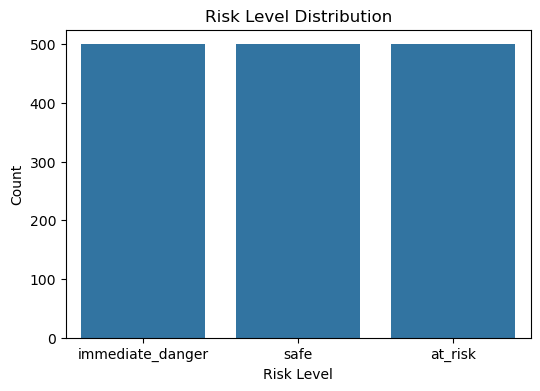

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of risk levels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='risk_level', order=df['risk_level'].value_counts().index)
plt.title("Risk Level Distribution")
plt.ylabel("Count")
plt.xlabel("Risk Level")
plt.show()


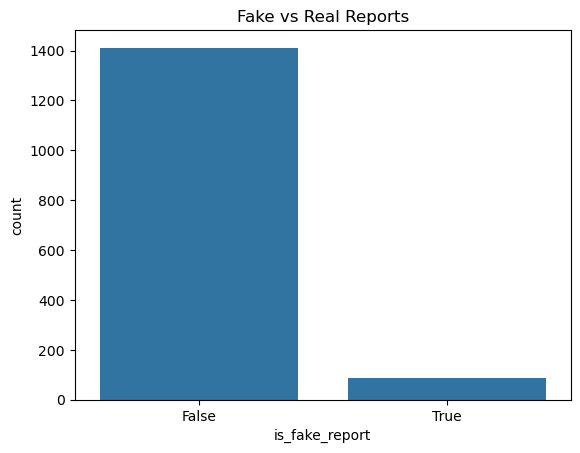

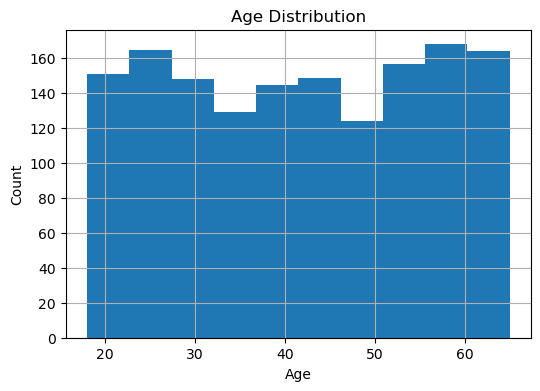

In [15]:
# Fake report distribution
sns.countplot(data=df, x='is_fake_report')
plt.title("Fake vs Real Reports")
plt.show()

# Age distribution
df['age'].hist(bins=10, figsize=(6, 4))
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()



### FEATURE ENGINEERING

In [16]:
#Risk key word counts
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
def count_words(text):
    return len(text.split())

def count_sentences(text):
    return text.count('.') + text.count('!') + text.count('?')

def count_all_caps(text):
    return sum(1 for word in text.split() if word.isupper())

def count_exclamations(text):
    return text.count('!')

# Risk keywords list (you can expand this)
risk_keywords = [
    'kill', 'hit', 'beat', 'threat', 'knife', 'gun', 'blood', 
    'abuse', 'danger', 'violence', 'escape', 'scream', 'stab', 'rape'
]

def contains_risk_keywords(text):
    text = text.lower()
    return any(keyword in text for keyword in risk_keywords)

df['clean_text'] = df['text'].apply(clean_text)

In [17]:
y = df['risk_level']  

In [18]:
#TF-IDF and Meta-features
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Basic Text Features
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['sentence_count'] = df['text'].apply(lambda x: len(re.split(r'[.!?]', str(x))) - 1)
df['uppercase_count'] = df['text'].apply(lambda x: sum(1 for w in str(x).split() if w.isupper()))
df['exclamation_count'] = df['text'].apply(lambda x: str(x).count('!'))

# Subjectivity & Polarity (Emotion)
df['subjectivity_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 3. Risk Keyword Count
risk_keywords = ['kill', 'hurt', 'stab', 'beat', 'abuse', 'die', 'murder', 'choke', 'hit', 'rape', 'blood']
df['risk_keyword_count'] = df['text'].apply(
    lambda x: sum(1 for word in str(x).lower().split() if word in risk_keywords)
)

# Sentiment vs Risk Level Mismatch
def check_mismatch(row):
    if row['risk_level'] == 'safe' and row['sentiment_score'] < -0.2:
        return 1
    elif row['risk_level'] == 'immediate_danger' and row['sentiment_score'] > 0.2:
        return 1
    else:
        return 0

df['sentiment_risk_mismatch'] = df.apply(check_mismatch, axis=1)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
X_tfidf = vectorizer.fit_transform(df['text'])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Combine All Features
meta_features = df[[
    'word_count', 'sentence_count', 'uppercase_count', 'exclamation_count',
    'subjectivity_score', 'sentiment_score', 'risk_keyword_count',
    'sentiment_risk_mismatch'
]].reset_index(drop=True)

X_final = pd.concat([meta_features, tfidf_df], axis=1)

# Target
y = df['risk_level']

# Print shape 
print("Final feature shape:", X_final.shape)
print("Target distribution:\n", y.value_counts())


Final feature shape: (1500, 157)
Target distribution:
 risk_level
immediate_danger    500
safe                500
at_risk             500
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_10868\95598677.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='risk_level', y='sentiment_score', palette='Set2')


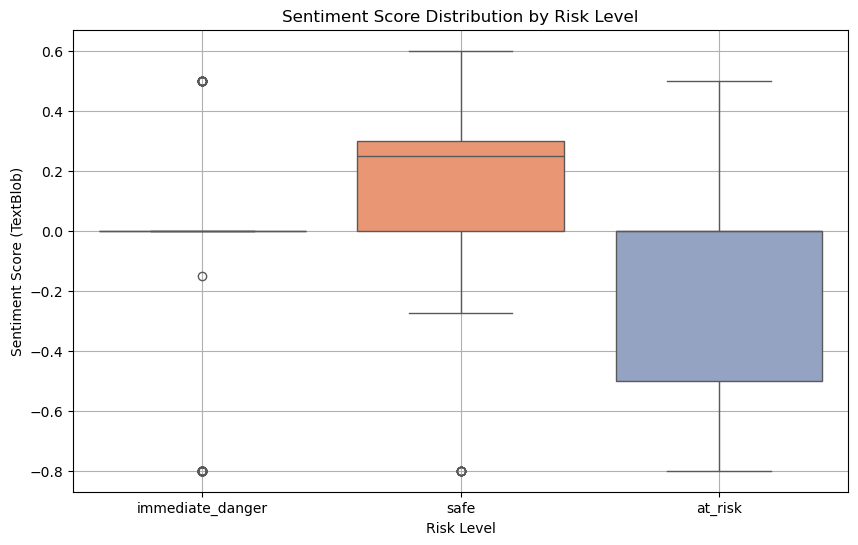

In [19]:
#Sentiment score
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='risk_level', y='sentiment_score', palette='Set2')
plt.title('Sentiment Score Distribution by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Sentiment Score (TextBlob)')
plt.grid(True)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_10868\3334880234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='risk_level', y='risk_keyword_count', palette='Set3')


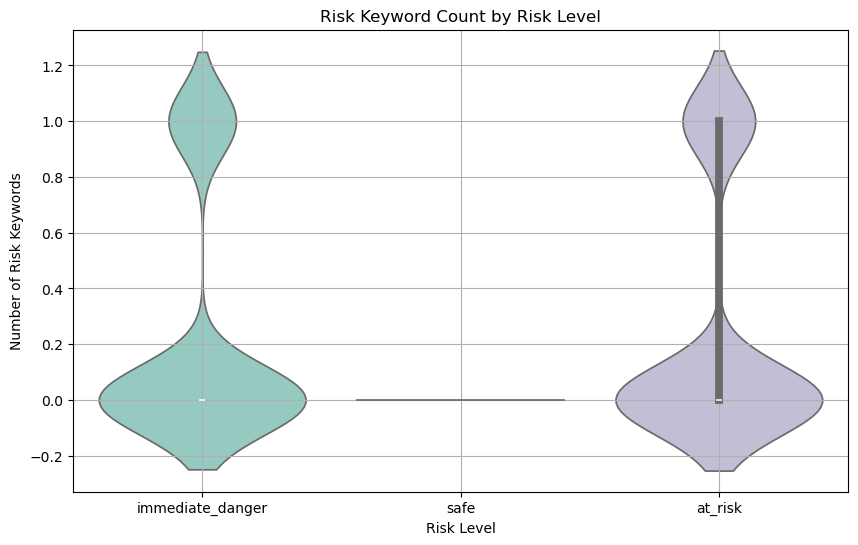

In [20]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='risk_level', y='risk_keyword_count', palette='Set3')
plt.title('Risk Keyword Count by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Number of Risk Keywords')
plt.grid(True)
plt.show()


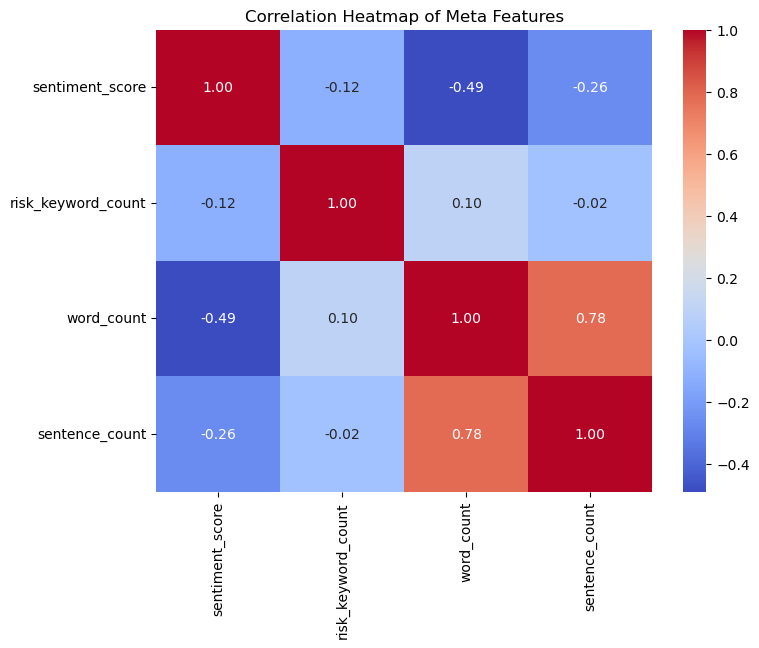

In [21]:
meta_features = ['sentiment_score', 'risk_keyword_count', 'word_count', 'sentence_count']

plt.figure(figsize=(8, 6))
sns.heatmap(df[meta_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Meta Features')
plt.show()


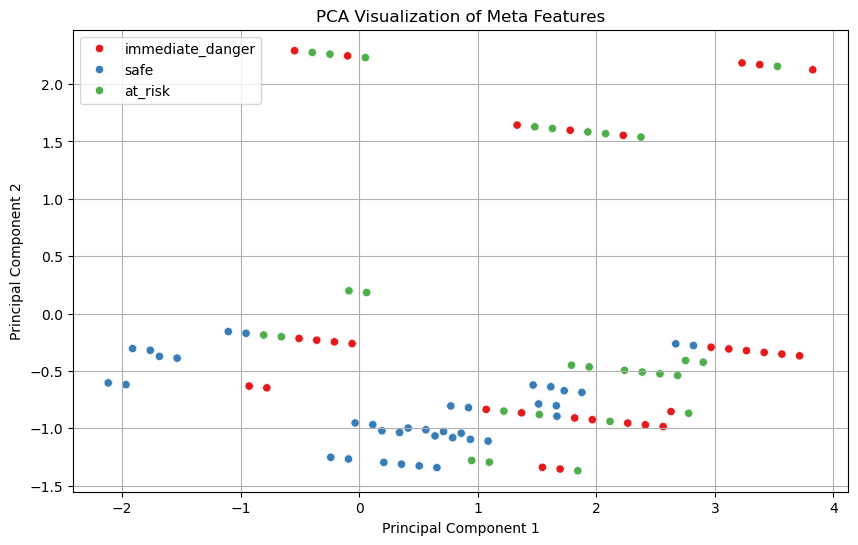

In [22]:
# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
X_scaled = StandardScaler().fit_transform(df[meta_features])

# PCA to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='risk_level', palette='Set1')
plt.title('PCA Visualization of Meta Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
df['clean_text'].shape


(1500,)

### MODELING 

#### Logistic Regression

In [27]:

# Features & target
X = df['clean_text']   # keep emojis
y = df['risk_level']   # safe, at_risk, immediate_danger

# Train-test split (stratify to keep balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# Define the simplified pipeline
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define the hyperparameters to tune. 
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Test unigrams and bigrams
    'clf__C': [0.1, 1.0, 10.0], # Regularization parameter
}

# GridSearchCV to find the best parameters
grid = GridSearchCV(pipeline_model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='f1_macro')
grid.fit(X_train, y_train)

# The rest of the notebook can use grid_search.best_estimator_ instead of pipeline_model
best_model = grid.best_estimator_



Fitting 3 folds for each of 6 candidates, totalling 18 fits


#### Random Forest

In [28]:
# Split
X = df[['clean_text', 'word_count', 'sentiment_score']]  # Example features
y = df['risk_level']
X_train_rm, X_test_rm, y_train_rm, y_test_rm = train_test_split(X, y, stratify=y, random_state=42)

# Define vectorizer and preprocessor
text_features = 'clean_text'
meta_features = ['word_count',  'sentiment_score']

preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(), text_features),
    ('meta', StandardScaler(), meta_features)
])

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Fit
pipeline.fit(X_train_rm, y_train_rm)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('meta', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### EVALUATION

Classification Report:                   precision    recall  f1-score   support

         at_risk       1.00      0.91      0.95       100
immediate_danger       0.92      1.00      0.96       100
            safe       1.00      1.00      1.00       100

        accuracy                           0.97       300
       macro avg       0.97      0.97      0.97       300
    weighted avg       0.97      0.97      0.97       300



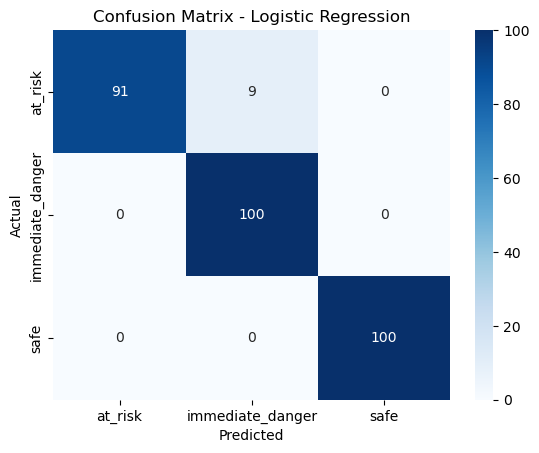

In [29]:
# Evaluation of Logistic Regression

# Evaluation
y_pred = grid.predict(X_test)

print("Classification Report:", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid.classes_,
            yticklabels=grid.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [30]:
# Evaluation of random forest
from sklearn.metrics import classification_report
y_pred_rm = pipeline.predict(X_test_rm)
print(classification_report(y_test_rm, y_pred_rm))


                  precision    recall  f1-score   support

         at_risk       0.97      0.94      0.95       125
immediate_danger       0.94      0.97      0.95       125
            safe       1.00      1.00      1.00       125

        accuracy                           0.97       375
       macro avg       0.97      0.97      0.97       375
    weighted avg       0.97      0.97      0.97       375



### DistilBERT

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# Prepare data
df = df[['clean_text', 'risk_level']].copy()
label_map = {label: idx for idx, label in enumerate(sorted(df["risk_level"].unique()))}
df["label"] = df["risk_level"].map(label_map)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["clean_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["clean_text", "risk_level"])
test_dataset = test_dataset.remove_columns(["clean_text", "risk_level"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=len(label_map)
)

# FIX: remove unsupported keyword
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",   # old: evaluation_strategy
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True)

def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics)

trainer.train()

#Evaluate model
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)




Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


#### Model Interpretation with SHAP

In [ ]:


# Get a sample text from the test set
X_test_text = test_df['clean_text'].iloc[[0]]  # double brackets keep proper shape

# Define a function that the SHAP explainer can use to get predictions from the model
def predict_proba_from_text(texts):
    # Tokenize the input text
    encoded = tokenizer(
        list(texts),  # works for Series, list, or numpy array
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # Move to same device as the model
    device = next(model.parameters()).device
    encoded = {k: v.to(device) for k, v in encoded.items()}

    # Get predictions from the model
    with torch.no_grad():
        logits = model(**encoded).logits

    # Apply softmax to get probabilities
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

# Create a SHAP text masker (important for correct token handling)
masker = shap.maskers.Text(tokenizer)

# Create a SHAP explainer with the masker
explainer = shap.Explainer(predict_proba_from_text, masker, algorithm="partition")

# Calculate SHAP values for the sample text
shap_values = explainer(X_test_text)

# The labels from your `label_map`
class_names = list(label_map.keys())

# Visualize the explanation
shap.plots.text(shap_values[0])


In [ ]:
### Save model for deployment
model.save_pretrained("./distilbert_femicide_model")
tokenizer.save_pretrained("./distilbert_femicide_model")
print("Model and tokenizer saved for deployment!")